### Perform EDA and analysis
**program:** 03_lr_mod_h100 <br>
**author:** chris chan<br>
**date:** jan 27,2021<br>
**desc:** Logistic Regression Model for Hot 100 <br>

**datasources:**<br>
- sb_analytic (balanced df thru 2010)
- billboard analytic (hot 100 thru 2019)
- spotify random (random thru 2020)

**log reg workflow (kf cv)**<br>
1. split 2 times (train,val,test)
2. select features / label
3. standardize if necessary
4. define a kfold split object
5. instantiate your model
6. cross val score: apply 4,5. fit the model
7. cross val predict: apply 4,5. get predicted vals on training set
8. get scores: based on 6, define the score you want (if not accuracy). Also get classification report (f1,precision, etc.)
9. confusion matrix: apply 7. based on training set
10. AUC/ROC: apply to validation set to evaluate model

In [3]:
from importlib import reload
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score , cross_val_predict

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [4]:
from sqlalchemy import create_engine
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split

**1. Bring in data**

In [6]:
sbdf=pd.read_csv(r'../data/clean/sbdf_clean.csv')
sbdf.head(3)

,SpotifyID,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,loudness,is_hit,year
0,285pBltuF7vW8TeWk8hdRR,0.511,0.566,6,0,0.200,0.3490,0.0,0.340,0.218,83.903,239836,-7.230,1,2018.0
1,7dt6x5M1jzdTEt8oCbisTK,0.680,0.578,10,1,0.040,0.3310,0.0,0.135,0.341,145.038,231267,-5.804,1,2018.0
2,78QR3Wp35dqAhFEc2qAGjE,0.897,0.662,1,0,0.292,0.0852,0.0,0.534,0.389,112.511,145543,-6.903,1,2019.0


**2. Create Label**
- this LR mod is based on 1980 or not (using 1960+)

In [7]:
sbdf['in80']=np.where( (sbdf['year'] >= 1980) & (sbdf['year']<1990),1,0)

**remove rows below 1960**

In [8]:
sbdf = sbdf[sbdf['year'] >= 1960] 

In [9]:
sbdf.columns = map(str.lower, sbdf.columns)

In [10]:
sbdf['decade'] = (sbdf.year//10*10).astype(int)

In [11]:
sbdf.decade.value_counts()

2000    6239
1990    3864
2010    3829
1980      91
1960       8
1970       4
Name: decade, dtype: int64

In [12]:
sbdf = sbdf[sbdf['decade'] >= 1990] 

In [13]:
sbdf['track_seconds'] = sbdf['duration_ms'] / 1000

In [14]:
sbdf.columns

Index(['spotifyid', 'danceability', 'energy', 'key', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'loudness', 'is_hit', 'year', 'in80', 'decade',
       'track_seconds'],
      dtype='object')

In [15]:
sbdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13932 entries, 0 to 14036
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   spotifyid         13932 non-null  object 
 1   danceability      13932 non-null  float64
 2   energy            13932 non-null  float64
 3   key               13932 non-null  int64  
 4   mode              13932 non-null  int64  
 5   speechiness       13932 non-null  float64
 6   acousticness      13932 non-null  float64
 7   instrumentalness  13932 non-null  float64
 8   liveness          13932 non-null  float64
 9   valence           13932 non-null  float64
 10  tempo             13932 non-null  float64
 11  duration_ms       13932 non-null  int64  
 12  loudness          13932 non-null  float64
 13  is_hit            13932 non-null  int64  
 14  year              13932 non-null  float64
 15  in80              13932 non-null  int64  
 16  decade            13932 non-null  int64 

Our goal is to predict whether or not the song is a hit or not. For the sake of simplicity, we'll split the data once, between a train set and a test set. *Of course, in practice, you'll want to cross validate with multiple splits of the data.*

**Manual K-fold**

In [16]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

# Split first to remove test data
df_train_st, df_test_st = train_test_split(sbdf, test_size=0.2, random_state=42 ) #, stratify=y)

# SPlit again between train and val
#df_train, df_test = train_test_split(df_train_st, test_size=0.25, random_state=42 ) #, stratify=y)

**a. scale your vars**

In [17]:
features = ['danceability', 'energy', 'key', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'loudness', 'track_seconds']
labels = ['is_hit']


# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train_st[features])
y_train = df_train_st[labels]

X_test = scaler.fit_transform(df_test_st[features])
y_test = df_test_st[labels]


In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)
X, y = np.array(X_train), np.array(y_train)

accuracies = []


for train_index, test_index in kf.split(X,y):

    X_train, y_train = X[train_index], y[train_index]    
    X_val, y_val = X[test_index], y[test_index] 

    # if needed, do preprocessing here

    clf = LogisticRegression()
    clf.fit(X_train,y_train)

    test_preds = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test,test_preds)

    train_preds = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)

    print(train_accuracy, test_accuracy, (train_accuracy - test_accuracy) )

    accuracies.append(accuracies)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

## New Method

**Macros**

In [18]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=12):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [19]:
# #Function used to plot the learning curve, roc curve, and confusing matrix for the given model
# def plot_model(model, X, y):
#     model.fit(X, y)
#     y_predict = model.predict(X)
#     y_predictprob = model.predict_proba(X)[:, 1]

#     LR_acc = np.round(np.mean(cross_val_score(model, X, y, scoring = 'accuracy', cv = 5)), 5)
#     LR_f1 = np.round(np.mean(cross_val_score(model, X, y, scoring = 'f1', cv = 5)), 5)
#     LR_prec = np.round(np.mean(cross_val_score(model, X, y, scoring = 'precision', cv = 5)), 5)
#     LR_recall = np.round(np.mean(cross_val_score(model, X, y, scoring = 'recall', cv = 5)), 5)
#     print(f'The base LR accuracy is: {LR_acc}')
#     print(f'The base LR f1 is: {LR_f1}')
#     print(f'The base LR precision is: {LR_prec}')
#     print(f'The base LR recall is: {LR_recall}')

    
#     m, train_err, test_err = learning_curve(model, X, y, cv = 5, scoring = 'f1', random_state = 42)
#     m_trainerr = np.mean(train_err, axis = 1)
#     m_testerr = np.mean(test_err, axis = 1)

#     print("train error", m_trainerr, "test error", m_testerr)
    
#     fpr, tpr, thr = roc_curve(y, y_predictprob)

#     plt.rcParams.update({'figure.figsize': (7, 5)})
#     plt.subplot(1,2,1)
#     plt.plot(m, m_trainerr, 'k', m, m_testerr, 'r')
#     plt.xlabel('Number of Samples', fontsize = 10)
#     plt.ylabel('F1', fontsize = 10)
#     plt.legend(['Training Error', 'Test Error'])
#     plt.subplot(1,2,2)
#     plt.plot(fpr, tpr)
#     print(f'AUC: {np.round(roc_auc_score(y_train, y_predictprob), 4)}')

#     conf_mat = confusion_matrix(y_train, y_predict)
#     cm = print_confusion_matrix(conf_mat, ['not a hit', 'is a hit'])
    
#     return LR_f1


In [37]:
#Function used to plot the learning curve, roc curve, and confusing matrix for the given model
#Function used to plot the learning curve, roc curve, and confusing matrix for the given model
def plot_model(model, X, y , X2, y2,threshold=0.5):
    model.fit(X, y)
    y_predict = model.predict(X)
    #y_predictprob = model.predict_proba(X)[:, 1]
    
    y_predictprob = (model.predict_proba(X)[:, 1] >=threshold).astype('int')

    LR_acc = np.round(np.mean(cross_val_score(model, X, y, scoring = 'accuracy', cv = 5)), 5)
    LR_f1 = np.round(np.mean(cross_val_score(model, X, y, scoring = 'f1', cv = 5)), 5)
    LR_prec = np.round(np.mean(cross_val_score(model, X, y, scoring = 'precision', cv = 5)), 5)
    LR_recall = np.round(np.mean(cross_val_score(model, X, y, scoring = 'recall', cv = 5)), 5)
    print(f'The base LR accuracy is: {LR_acc}')
    print(f'The base LR f1 is: {LR_f1}')
    print(f'The base LR precision is: {LR_prec}')
    print(f'The base LR recall is: {LR_recall}')

    #print("train : all metrics:", metrics.classification_report(y,y_predictprob))

    print("Precision: {:6.4f},   Recall: {:6.4f}, Accuracy: {:6.4f}".format(precision_score(y, y_predictprob),
                                                        recall_score(y, y_predictprob) ,
                                                        accuracy_score(y,y_predictprob)))
    
    
    m, train_err, test_err = learning_curve(model, X, y, cv = 5, scoring = 'f1', random_state = 42)
    m_trainerr = np.mean(train_err, axis = 1)
    m_testerr = np.mean(test_err, axis = 1)

    print("train error", m_trainerr.mean(), "test error", m_testerr.mean())
    print("y pred proba ",y_predictprob)
    
    
    # try
    
    ns2_probs = [0 for _ in range(len(y2))]
    y2_predict = model.predict(X2)
    y2_predictprobs = model.predict_proba(X2)[:, 1]
    y2_predictprob = (model.predict_proba(X2)[:, 1]>=threshold).astype('int')
    
    print('predictions prob',y2_predictprobs)
    #print("test : all metrics: ", metrics.classification_report(y2,y2_predictprob))    
    print("Precision: {:6.4f},   Recall: {:6.4f}, Accuracy: {:6.4f}".format(precision_score(y2, y2_predictprob),
                                                        recall_score(y2, y2_predictprob) ,
                                                        accuracy_score(y2,y2_predictprob)))
    
    
    
    fpr, tpr, thr = roc_curve(y2, y2_predictprobs)
    print('fpr',fpr,'tpr',tpr)
    ns2_auc = roc_auc_score(y2, ns2_probs)
    ns2_fpr, ns2_tpr, _ = roc_curve(y2, ns2_probs)

#     optimal_idx = np.argmax(tpr - fpr)
#     optimal_threshold = thresholds[optimal_idx]
#     print("optimal idx", optimal_idx, "optimal threshold", optimal_threshold)
    
    plt.rcParams.update({'figure.figsize': (7, 5)})
    plt.subplot(1,2,1)
    plt.plot(m, m_trainerr, 'k', m, m_testerr, 'r')
    plt.xlabel('Number of Samples', fontsize = 10)
    plt.ylabel('F1', fontsize = 10)
    plt.legend(['Training Error', 'Test Error'])
    plt.subplot(1,2,2)
    plt.plot(fpr, tpr)
    print(f'AUC: {np.round(roc_auc_score(y2, y2_predictprobs), 4)}')

    pyplot.plot(ns2_fpr, ns2_tpr, linestyle='--', label='No Skill')
    
    conf_mat = confusion_matrix(y2, y2_predictprob)
    cm = print_confusion_matrix(conf_mat, ['not a hit', 'is a hit'])
    
    return LR_f1

In [21]:
def model_dropcols_opt(model, X, y, basef1, ncv, print_f1s = False):
    
    # feature columns that get dropped from X because when dropped
    # they cause f1 to increase or not change at all
    
    cols_drop = []
    counter = 0
    best_delta = ('name', 1)
    while best_delta[1] >= 0:
        
        if counter > len(X.columns) - 2:
            break
        
        deltas = []
        
        for i in X.columns:

            f1_cval = np.round(np.mean(cross_val_score(model, X.drop(columns = i), y, scoring = 'f1', cv = ncv)), 5)
            deltas.append((i, f1_cval - basef1))
        
        deltas_sort = sorted(deltas, key = lambda x: x[0], reverse = True)
        best_delta = deltas_sort[0]
        
        if print_f1s == True:
            print(best_delta)
            
        if best_delta[1] >= 0:
            cols_drop.append(best_delta[0])
            X = X.drop(columns = best_delta[0])
            
    return cols_drop

### 3. models

In [22]:
sbdf.columns

Index(['spotifyid', 'danceability', 'energy', 'key', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'loudness', 'is_hit', 'year', 'in80', 'decade',
       'track_seconds'],
      dtype='object')

In [23]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, accuracy_score

# Establishing X and y
# y = sbdf['is_hit']
# X = sbdf.drop(columns = ['is_hit','spotifyid','in80','decade','year','duration_ms'])

# # Train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# # Standard scaling of the train and test data
# r_ssX = StandardScaler()
# X_train_scaled = pd.DataFrame(r_ssX.fit_transform(X_train), columns = X_train.columns)
# X_test_scaled = pd.DataFrame(r_ssX.fit_transform(X_test), columns = X_test.columns)

In [24]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

# Establishing X and y
y = sbdf['is_hit']
X = sbdf.drop(columns = ['is_hit','spotifyid','decade','year','duration_ms'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

r_ssX = StandardScaler()
X_train_scaled = pd.DataFrame(r_ssX.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(r_ssX.fit_transform(X_test), columns = X_test.columns)

X2_train, X2_test,  y2_train,y2_test = train_test_split(X_train_scaled,y_train, test_size = 0.25, random_state = 42)


**Dummy Classifier**

The base LR accuracy is: 0.52525
The base LR f1 is: 0.61252
The base LR precision is: 0.60986
The base LR recall is: 0.61565
Precision: 0.6011,   Recall: 0.6013, Accuracy: 0.5135
train error 0.6120014976816721 test error 0.6108768527908743
y pred proba  [1 0 1 ... 0 0 1]
Precision: 0.6050,   Recall: 0.6000, Accuracy: 0.5142
fpr [0.         0.62209842 1.        ] tpr [0.  0.6 1. ]
AUC: 0.489


0.61252

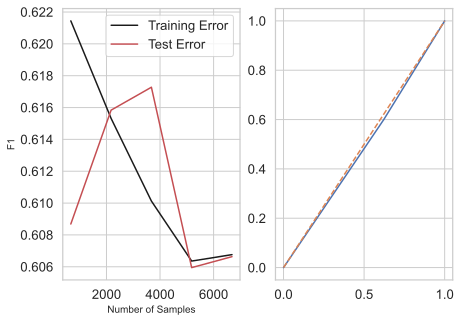

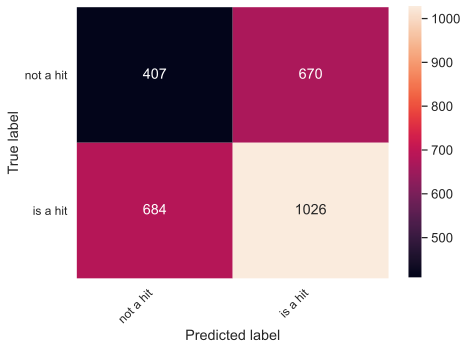

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import learning_curve

dc = DummyClassifier(strategy='stratified')
plot_model(dc,X2_train,y2_train,X2_test,y2_test)

**Logistic Regression**

Base logistic regression

The base LR accuracy is: 0.76777
The base LR f1 is: 0.82665
The base LR precision is: 0.75861
The base LR recall is: 0.90818
Precision: 0.7588,   Recall: 0.9078, Accuracy: 0.7678
train error 0.8325707559588208 test error 0.8254061625170894
y pred proba  [1 1 0 ... 1 0 1]
predictions prob [0.53573055 0.42022207 0.23739897 ... 0.80607205 0.83770979 0.36467469]
Precision: 0.7581,   Recall: 0.9129, Accuracy: 0.7679
fpr [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.28505107e-04
 9.28505107e-04 1.85701021e-03 1.85701021e-03 2.78551532e-03
 2.78551532e-03 3.71402043e-03 3.71402043e-03 4.64252553e-03
 4.64252553e-03 6.49953575e-03 6.49953575e-03 7.42804085e-03
 7.42804085e-03 8.35654596e-03 8.35654596e-03 9.28505107e-03
 9.28505107e-03 1.02135562e-02 1.02135562e-02 1.11420613e-02
 1.11420613e-02 1.20705664e-02 1.20705664e-02 1.29990715e-02
 1.29990715e-02 1.39275766e-02 1.39275766e-02 1.48560817e-02
 1.48560817e-02 1.57845868e-02 1.57845868e-02 1.67130919e-02
 1.67130919e-02 1.85701021e-02 1

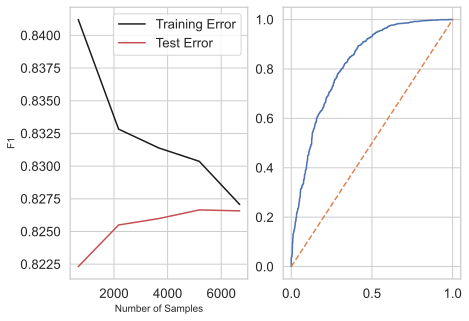

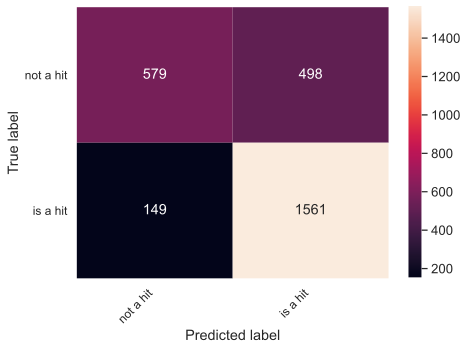

In [38]:
lr = LogisticRegression(random_state=42)
rlr_basef1 = plot_model(lr, X2_train, y2_train,X2_test,y2_test)

**Grid search on C after dropping those initial columns**

In [32]:
from sklearn.model_selection import GridSearchCV

lrparam_grid = {'C': np.arange(0.10, 1, 0.01)}

lr_grid = GridSearchCV(lr, lrparam_grid, scoring = 'f1', cv = 5)
lr_grid.fit(X2_train, y2_train)
print(lr_grid.best_params_)
print(lr_grid.best_score_)

{'C': 0.9799999999999995}
0.8266499246498894


The base LR accuracy is: 0.76765
The base LR f1 is: 0.82658
The base LR precision is: 0.75849
The base LR recall is: 0.90818
Precision: 0.7588,   Recall: 0.9078, Accuracy: 0.7678
train error 0.8325640129615781 test error 0.8253912802354586
y pred proba  [1 1 0 ... 1 0 1]
Precision: 0.7581,   Recall: 0.9129, Accuracy: 0.7679
AUC: 0.7252


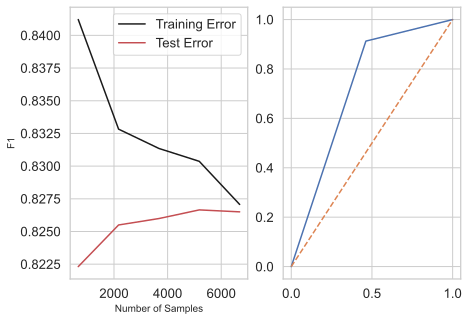

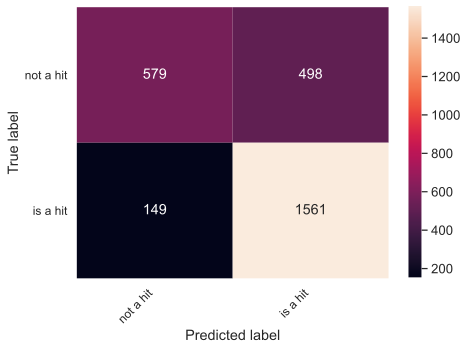

In [41]:
lr = LogisticRegression(C = 0.97, random_state = 40)
rlr_optf1 = plot_model(lr, X2_train, y2_train, X2_test, y2_test)

**Feature importance**

In [37]:
lr = LogisticRegression(C = 0.97, random_state = 40)
lr.fit(X2_train, y2_train)

lrimportances = sorted([(i, j) for i, j in zip(X2_train.columns, lr.coef_[0])],
       key = lambda x: abs(x[1]), reverse = True)

print(lrimportances)
lr_drops = [i[0] for i in lrimportances if abs(i[1]) < 0.10]
lr_drops

[('instrumentalness', -0.9910763915329319), ('loudness', 0.8638237127071184), ('danceability', 0.6417056516649539), ('acousticness', -0.5107423883374114), ('valence', -0.4186295439975151), ('energy', -0.3250492260587739), ('liveness', -0.16525517797504868), ('speechiness', -0.11542542941781186), ('track_seconds', 0.10755442971476348), ('tempo', 0.08409132958474647), ('mode', 0.019899635081122996), ('key', -0.014809648224801363), ('in80', 0.0)]


['tempo', 'mode', 'key', 'in80']

The base LR accuracy is: 0.76765
The base LR f1 is: 0.8267
The base LR precision is: 0.75815
The base LR recall is: 0.90897
Precision: 0.7594,   Recall: 0.9090, Accuracy: 0.7688
train error 0.831254523126163 test error 0.8260967494093551
y pred proba  [1 1 0 ... 1 0 1]
Precision: 0.7625,   Recall: 0.9164, Accuracy: 0.7736
AUC: 0.7316


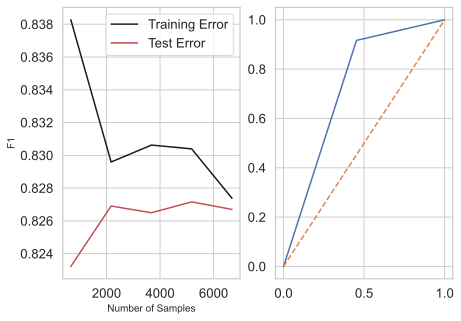

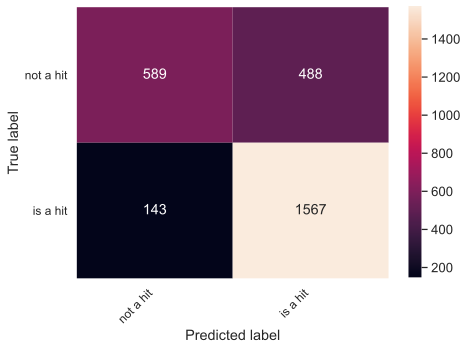

In [44]:
X3_train = X2_train.drop(lr_drops, axis = 1)
X3_test = X2_test.drop(lr_drops, axis = 1)

lr = LogisticRegression(C = 0.97, random_state = 42)

rlr_thirdf1 = plot_model(lr, X3_train, y2_train, X3_test, y2_test)

**changing threshold to bring precision up**

The base LR accuracy is: 0.76765
The base LR f1 is: 0.8267
The base LR precision is: 0.75815
The base LR recall is: 0.90897
Precision: 0.7946,   Recall: 0.7938, Accuracy: 0.7491
train error 0.831254523126163 test error 0.8260967494093551
y pred proba  [1 1 0 ... 1 0 1]
Precision: 0.7984,   Recall: 0.8082, Accuracy: 0.7571
AUC: 0.7421


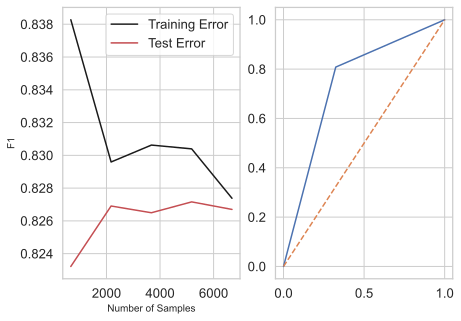

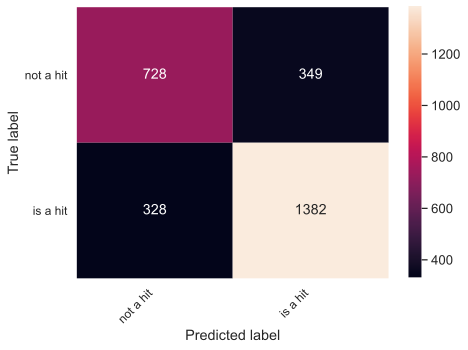

In [47]:
lr = LogisticRegression(C = 0.97, random_state = 42)

rlr_fourthf1 = plot_model(lr, X3_train, y2_train, X3_test, y2_test, 0.63)

**cols to drop**

In [28]:
sbdf.columns

Index(['spotifyid', 'danceability', 'energy', 'key', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'loudness', 'is_hit', 'year', 'in80', 'decade',
       'track_seconds'],
      dtype='object')

In [29]:
lr_colsdrop = model_dropcols_opt(lr, X2_train, y2_train, rlr_basef1, 5, True)

('valence', -0.005049999999999999)


**Refitting based on new cols**

In [30]:
lr_Xtrain_scaled = X_train_scaled.drop(lr_colsdrop, axis = 1)
lr_Xtrain_scaled.columns
#rlr_secondf1 = plot_model(lr, lr_Xtrain_scaled, y_train)

Index(['danceability', 'energy', 'key', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'loudness', 'in80',
       'track_seconds'],
      dtype='object')

In [ ]:
**cols to drop**

sbdf.columns

lr_colsdrop = model_dropcols_opt(lr, X2_train, y2_train, rlr_basef1, 5, True)

**Refitting based on new cols**

lr_Xtrain_scaled = X_train_scaled.drop(lr_colsdrop, axis = 1)
lr_Xtrain_scaled.columns
#rlr_secondf1 = plot_model(lr, lr_Xtrain_scaled, y_train)

## 4. Cross Validation

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

# Split first to remove test data
df_train_st, df_test_st = train_test_split(sbdf, test_size=0.2, random_state=42 ) #, stratify=y)

# SPlit again between train and val
df_train, df_test = train_test_split(df_train_st, test_size=0.25, random_state=42 ) #, stratify=y)

**a. scale your vars**

In [ ]:
features1 = ['acousticness','danceability','energy','loudness','valence','track_seconds']
features = ['acousticness','danceability','energy','loudness','valence','track_seconds','liveness']

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = df_train['is_hit']

X_test = scaler.fit_transform(df_test[features])
y_test = df_test['is_hit']


**b. fit model and get accuracy**<br>
**BELOW we have 2 different ways of getting the same CV answers:**

1. you can instantiate an skfold header OR do it directly in steps below
2. you MUST instantiate your logistic regression
3. generally speaking you want to assign your MODEL FIT to an object.<br>
. you should probably ALWAYS do these 2 steps:<br>
    . assign accuracy (during the fit)<br>
    . assign predicted values (during the fit)<br>
. to do a fit you can do the following:<br>
    . model_selection.cross_val_score: this automatically gives you your accuracy scores<br>
    . cross_val_predict: this will give you your predictors SO THAT you can compute your accuracy and other measures based on these PREDICTED values:<br>
        . metrics.accuracy_score: will give you the accuracy score<br>
        . metrics.classification_report: will give you precision/recall/f1/support/accuracy<br>
<br>
. Model 1 below seems to be more comprehensive and flexible

**Model 1:**

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV



**define kfold, fit model, score**

In [ ]:
#skfold = StratifiedKFold(n_splits=5, random_state=42)
skfold = KFold(n_splits=5, shuffle=True, random_state=42)
model_skfold = LogisticRegression()

# accuracy
results_skfold = cross_val_score(model_skfold, X_train, y_train, cv=skfold)
predict_skfold = cross_val_predict(model_skfold, X_train, y_train, cv=skfold)


print("Accuracy: %.2f%%" % (results_skfold.mean()*100.0))
print(metrics.classification_report(y_train,predict_skfold))

**check above results. can we improve model?**

**perform scores on true validation for comparison**

In [ ]:
predict_skfold_val = cross_val_predict(model_skfold, X_test, y_test, cv=skfold)
print(metrics.classification_report(y_test,predict_skfold_val))

**If good with above, fit the model**

In [ ]:
results_fit = model_skfold.fit(X_train,y_train)


**run everything on validation**

**Confusion Matrix (back to TRAINING DATA : based on PREDICTED you have your confusion matrix)**

In [ ]:
confusion_matrix(df_test['is_hit'], predict_skfold_val)

In [ ]:
from sklearn.metrics import confusion_matrix

labels = [0,1]
cm = confusion_matrix(df_test['is_hit'], predict_skfold_val, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confmx_lr.png')
plt.show()

**ROC/AUC**

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = results_fit.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

## TESTING

#### 3. Full Model with more features

We can incorporate more features using the sklearn Logistic Regression implemetation.

**a. TRAINING: standardize your features**

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

# Split first to remove test data
df_train_st, df_test_st = train_test_split(sbdf, test_size=0.2, random_state=42 ) #, stratify=y)

# SPlit again between train and val
df_train, df_test = train_test_split(df_train_st, test_size=0.2, random_state=42 ) #, stratify=y)

In [ ]:
features = ['acousticness','danceability','energy','loudness','valence','track_seconds']

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = df_train['is_hit']

X_test = scaler.fit_transform(df_test[features])
y_test = df_test['is_hit']


In [ ]:
# from sklearn.preprocessing import StandardScaler
# features = ['energy','mode','acousticness','danceability','energy','loudness','key','instrumentalness']

# # Since we're using more than one feature, let's scale our features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(df_train[features])
# y_train = df_train['in80']

In [ ]:
print(X_train)

**b. TRAINING: Fit a model**

In [ ]:
lm_3 = LogisticRegression()  # We'll also regularize our features

In [ ]:
lm_3.fit(X_train, y_train)

**c. TEST: standardize your features**

In [ ]:
X_test = scaler.transform(df_test[features])
y_test = df_test['is_hit']

preds = lm_3.predict(X_test)

**d. Confusion matrix**

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

confusion_matrix(y_test, preds)

**e. ROC Curve**

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lm_3.predict_proba(X_test)[:,1])

In [ ]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

In [ ]:
plot_roc(df_test['is_hit'], lm_3.predict_proba(X_test)[:, 1])

**f. Precision and Recall**

In [ ]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

# using the default threshold of 0.5, which is what vanilla predict does
y_predict = lm_3.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

**Whenver my "hit alarm (prediction)" went off, how many times was it actually a hit?? 69%
Whenever there was a true hit, how many times did i predict it to be a hit?? **

- what's more important

In [ ]:
# using the new threshold of 0.06
y_predict = (lm_3.predict_proba(X_test)[:,1] > 0.5)
print("Threshold of 0.06:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

**If i'm prediction a lot more hits (by decreasing my threshold) I'm allowing more false positives - or DECREASING my precision. However I might INCREASE my recall because I've practially predicted all of the hits accordingly**

In [ ]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm_3.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as hit)');
plt.title('Precision and Recall Curves');

In [ ]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

**CC: F1 score** - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.701.

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

**g. F1 scores**

In [ ]:
# Or we can just ask sklearn
y_predict = lm_3.predict(X_test)
f1_score(y_test, y_predict)

In [ ]:
# What about the threshold of 0.06?
y_predict = (lm_3.predict_proba(X_test)[:, 1] > 0.50)
f1_score(y_test, y_predict)

**h. Accuracy**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict)
#accuracy_score(y_test, y_predict, normalize=False)

## The ROC curve

We've already seen that we don't have to accept a 50% threshold cutoff. As we've seen, we can plot our models with different thresholds on the same chart and get a ROC curve. This curve plots the *true positive rate* on the y axis, and the *false positive rate* on the x axis. 

In [ ]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lm_3.predict_proba(X_test)[:,1])

In [ ]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for hits problem');
print("ROC AUC score = ", roc_auc_score(y_test, lm_3.predict_proba(X_test)[:,1]))